# Karate Club Semi-supervised learning [Generating node embeddings]

## Importing modules

In [8]:
# Import PyTorch base
import os
import torch
import numpy as np
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.3.0+cu121


In [2]:
?# Install PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 38.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
# Visualizing tools
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

## Importing the Dataset

In [4]:
# Load dataset
from torch_geometric.datasets import KarateClub
dataset = KarateClub()

# Print details
print(f'Dataset name: {dataset}:')
print(f'No. of graphs: {len(dataset)}')
print(f'No. of features: {dataset.num_features}')
print(f'No. of classes: {dataset.num_classes}')

Dataset name: KarateClub():
No. of graphs: 1
No. of features: 34
No. of classes: 4


In [5]:
# Get graph object
data = dataset[0]
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


## Building a GNN model

Using Graph Convolution Layer (GCN) by Kipf et al. (2017)

In [54]:
# Import GCN layer
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # For reproducability
        torch.manual_seed(1234)

        # Define GCN layers
        self.gcn1 = GCNConv(in_channels=dataset.num_features, out_channels=4)
        self.gcn2 = GCNConv(in_channels=4, out_channels=4)
        self.gcn3 = GCNConv(in_channels=4, out_channels=2)
        self.linear = Linear(2, dataset.num_classes)

    # Forward progpagation function
    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = h.tanh()
        h = self.gcn2(h, edge_index)
        h = h.tanh()
        h = self.gcn3(h, edge_index)
        h = h.tanh()

        # Apply linear classifier
        out = self.linear(h)

        return out, h

In [55]:
# Instantiate the model
model = GCN()
print(model)

GCN(
  (gcn1): GCNConv(34, 4)
  (gcn2): GCNConv(4, 4)
  (gcn3): GCNConv(4, 2)
  (linear): Linear(in_features=2, out_features=4, bias=True)
)


## Visualizing the Node embeddings

In [56]:
# Convert graph to networkx object
from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected=True)

In [57]:
def plot_node_embedding(h, caption="GCN layer node embedding"):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    feature_representations = {node: h[node] for node in G.nodes()}
    nx.draw(G, pos= feature_representations, with_labels=True, node_color=data.y, cmap="Set3")
    plt.title(caption)
    plt.show()

In [58]:
# Pass Graph through random initialized model
_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

Embedding shape: [34, 2]


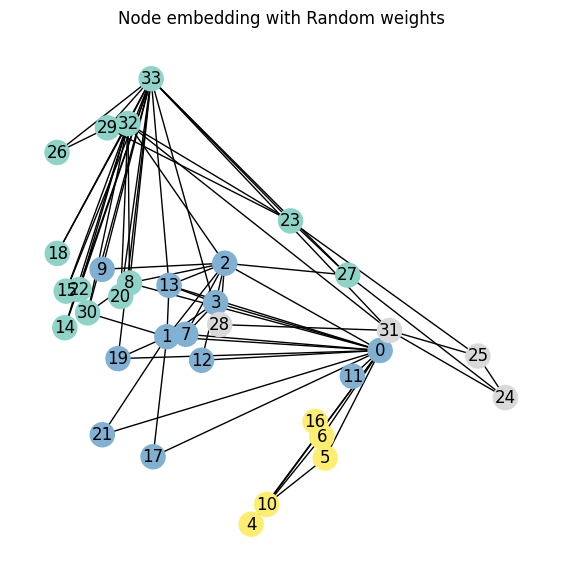

In [59]:
# Plot this embedding
plot_node_embedding(h, caption="Node embedding with Random weights")

### Training loop

In [60]:
# Set optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

# List to store mid-trinaing embeddings
embeddings = []

def train(data):
      # Set train mode
      model.train()

      # Zero gradients
      optimizer.zero_grad()

      # Forward pass
      out, h = model(data.x, data.edge_index)

      # Calculate loss
      loss = loss_fn(out[data.train_mask], data.y[data.train_mask])

      # Backpropagate gradients
      loss.backward()

      # Update weights
      optimizer.step()

      return loss, h

# Training loop
for epoch in range(401):

    # Train model
    loss, h = train(data)

    # Add embedding to list
    embeddings.append(h)

    if epoch % 10 == 0:
      # Plot node embedding while training
      #plot_node_embedding(h, caption=f'Epoch: {epoch} Loss: {loss}')

      print(f'Epoch: {epoch} Loss {loss}')

Epoch: 0 Loss 1.432432770729065
Epoch: 10 Loss 1.3560938835144043
Epoch: 20 Loss 1.2101788520812988
Epoch: 30 Loss 0.989616870880127
Epoch: 40 Loss 0.7633956074714661
Epoch: 50 Loss 0.5663382411003113
Epoch: 60 Loss 0.41873300075531006
Epoch: 70 Loss 0.32118016481399536
Epoch: 80 Loss 0.25708118081092834
Epoch: 90 Loss 0.2132289558649063
Epoch: 100 Loss 0.18167956173419952
Epoch: 110 Loss 0.15795594453811646
Epoch: 120 Loss 0.13946591317653656
Epoch: 130 Loss 0.1246333196759224
Epoch: 140 Loss 0.11246153712272644
Epoch: 150 Loss 0.10229171812534332
Epoch: 160 Loss 0.09366888552904129
Epoch: 170 Loss 0.08626881241798401
Epoch: 180 Loss 0.07985314726829529
Epoch: 190 Loss 0.07424206286668777
Epoch: 200 Loss 0.06929749995470047
Epoch: 210 Loss 0.06491116434335709
Epoch: 220 Loss 0.06099715456366539
Epoch: 230 Loss 0.05748595669865608
Epoch: 240 Loss 0.05432107672095299
Epoch: 250 Loss 0.05145587399601936
Epoch: 260 Loss 0.048851799219846725
Epoch: 270 Loss 0.04647626727819443
Epoch: 280 L

## Generate training video

In [34]:
import matplotlib.animation as animation
from IPython.display import HTML

In [61]:
fig= plt.figure(dpi=150)
ax = fig.subplots()

def draw_embeddings(i):
    # Get each embedding
    h = embeddings[i]
    h = h.detach().cpu().numpy()
    feature_representations = {node: h[node] for node in G.nodes()}

    ax.cla()
    ax.axis('off')
    ax.set_title('Karate club network node embeddings for Epoch: %d' % i)

    # Draw graph
    nx.draw(G, pos=feature_representations, with_labels=True, node_color=data.y, cmap="Set3", ax=ax)
    plt.close()
plt.close()

In [62]:
anim = animation.FuncAnimation(fig, draw_embeddings, frames=len(embeddings), interval=20)
HTML(anim.to_html5_video())